# Overall schema and idea

- Find what errors are most common with a ground truth
- Compare the results with https://link.springer.com/chapter/10.1007/978-3-030-45442-5_13#Bib1
- Try and reduce the overfitting by messing with the probability distributions found 
- Compare many perturbers 

In [9]:
files.upload()

Saving recognized_text.csv to recognized_text.csv


{'recognized_text.csv': b',filename,identity,ocrClean\n0,TRAIN_00001.jpg,BALTHAZAR,BALTHALAR\n1,TRAIN_00002.jpg,SIMON,SI VOW\n2,TRAIN_00003.jpg,BENES,BENE S\n3,TRAIN_00004.jpg,LA LOVE,LA LOVE\n4,TRAIN_00005.jpg,DAPHNE,: {) (P HVE\n5,TRAIN_00006.jpg,LUCIE,LOCIE\n6,TRAIN_00007.jpg,NASSIM,\n7,TRAIN_00008.jpg,ASSRAOUI,ON SEA NEG MR AIE: EE AGSRA OI\n8,TRAIN_00009.jpg,LAVIAN,: \xc2\xa5 LAV IVAN\n9,TRAIN_00010.jpg,MAEVA,HAE VA NATE NE NAISSANCE CLASSE\n10,TRAIN_00011.jpg,EMMA,EWM G\n11,TRAIN_00012.jpg,MOULINIER,: FEUL RW)\n12,TRAIN_00013.jpg,ELISE,BLE SK\n13,TRAIN_00014.jpg,HONNERT,HON NE RT\n14,TRAIN_00015.jpg,MATHEO,MATHEO\n15,TRAIN_00016.jpg,PETITDIDIER,: PETITOOTOOTER\n16,TRAIN_00017.jpg,PAULINE,PAVIRWE\n17,TRAIN_00018.jpg,LOUVENAZ,: LOUYVE WAZ\n18,TRAIN_00019.jpg,BOURQUIN,BOVRAUTY\n19,TRAIN_00020.jpg,ROMAIN,ROM4SI WV\n20,TRAIN_00021.jpg,ASMA,. FONE\n21,TRAIN_00022.jpg,CYRIELLE,CYRI ELLE\n22,TRAIN_00023.jpg,LILOU,LT LOU\n23,TRAIN_00024.jpg,ESTEBANN,: \xc2\xa35 BEH ANO\n24,TRAIN_00025.jpg

In [8]:
import os
from google.colab import files

if 'kaggle.json' not in os.listdir():
    files.upload()

    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [10]:
import zipfile
import os

!kaggle datasets download -d landlord/handwriting-recognition

if 'written_name_train_v2.csv' not in os.listdir():
    with zipfile.ZipFile(f'handwriting-recognition.zip', 'r') as zipref:
        zipref.extractall('./')

 99% 1.25G/1.26G [00:14<00:00, 130MB/s]
100% 1.26G/1.26G [00:14<00:00, 90.5MB/s]


In [11]:
import pandas as pd

IMAGES_DIRECTORY = 'train_v2/train'
df = pd.read_csv('written_name_train_v2.csv')
df.rename(columns=lambda t: t.lower(), inplace=True)

# Dataset Construction

https://pypi.org/project/pytesseract/

In [12]:
%%capture
!sudo apt install tesseract-ocr
!pip install pytesseract

In [13]:
import pytesseract 
import string
import re

from PIL import Image

def clean_text(ocr):

    clean = ocr.upper()

    # remove everything that is before 'NOM' 
    # if 'NOM' is not found, keep everything
    rx = re.compile(r'NOM(.+)', re.DOTALL)
    try:
        clean = re.findall(rx, clean)[0]
    except IndexError:
        pass

    # remove whitespaces
    rx = re.compile(r'[{}]'.format(string.whitespace))
    clean = ' '.join([x for x in re.split(rx, clean) if len(x)>0 and x!=' '])

    return clean 

def read_text(img, imgdir, clean=True):
    ocr = pytesseract.image_to_string(Image.open(imgdir + '/' + img))
    return clean_text(ocr) if clean else ocr

In [14]:
# upload 'recognized_text'.csv
# files.upload()

In [15]:
from tqdm.notebook import tqdm
pd.options.mode.chained_assignment = None

train_more = False
if train_more:
    L = len(df.index)
    step = 10
    # bigdf = pd.DataFrame(columns=df.columns)
    # number of preread documents
    bigdf = pd.read_csv('recognized_text.csv', usecols=('filename', 'identity', 'ocrClean'), index_col=0)
    start = int(len(bigdf.index) / step)

    for i in tqdm(range(start, int(L/step))):
        df2 = df.iloc[i*step : (i+1)*step]
        df2['ocrClean'] = df2.filename.apply(read_text, imgdir=IMAGES_DIRECTORY, clean=True)
        df2.to_csv('recognized_text.csv', mode='a', header=False)
        
    files.download('recognized_text.csv')


In [16]:
df3 = pd.read_csv('recognized_text.csv', index_col=0)
df3.dropna(inplace=True)
df3.identity = df3.identity.apply(lambda t: t.upper())

In [17]:
df_train = df3.sample(frac=0.8, replace=False, random_state=1444)
df_test = df3.loc[set(df3.index).difference(df_train.index)]

## Improvements to the OCR tech

https://www.kaggle.com/data/40647

https://stackoverflow.com/questions/9480013/image-processing-to-improve-tesseract-ocr-accuracy

### Needleman-Wunsch

In [18]:
import numpy as np
from numba import njit
import string

# https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5
@njit
def nw(x, y, match = 1, mismatch = 1, gap = 1):
    # align x to match y
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

### Comparison

In [19]:
# some debug instruments 
from IPython.display import Image as NBImage, display

def show_image(number):
    img = IMAGES_DIRECTORY + f'/TRAIN_{number:05d}.jpg'
    display(NBImage(img))

def read_text_fromid(id, clean=True):
    ocr = pytesseract.image_to_string(Image.open(IMAGES_DIRECTORY \
                                                 + f'/TRAIN_{id:05d}.jpg'))
    return clean_text(ocr) if clean else ocr

In [20]:
import cv2
from google.colab.patches import cv2_imshow

# Image processing

def compare_results(df, id):

    img_name = IMAGES_DIRECTORY + '/' + df.filename.loc[id]
    img = cv2.imread(img_name)
    # img = cv2.resize(img, None, fx=1.2, fy=1.2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((1,1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=10)
    img = cv2.erode(img, kernel, iterations=10)

    """
    If no result was found, cropping the image can get something
    """
    # img = img[:, 10:]

    img = cv2.threshold(cv2.medianBlur(img, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Text interpretation

    c = df.ocrClean.loc[id]
    t = df.identity.loc[id]
    # r = df.ocrRaw.iloc[id]
    a, b = nw(c, t)

    r1 = pytesseract.image_to_string(img)
    c1 = clean_text(r1)
    a1, b1 = nw(c1, t)

    # Output

    print('Image id : ', id)
    print('-'*20)

    show_image(id+1)
    # print('Raw interpretation : ', r.strip(string.whitespace))
    # print('-'*20)
    print('Clean interpretation : ', c)
    print('-'*20)
    print('True text : ', t)
    print('-'*20)
    print('NW comparison : ', '\n', a, '\n', b)
    print('-'*20)

    cv2_imshow(img)
    # print('Raw interpretation : ', r1.strip(string.whitespace))
    # print('-'*20)
    print('Clean interpretation : ', c1)
    print('-'*20)
    print('True text : ', t)
    print('-'*20)
    print('NW comparison : ', '\n', a1, '\n', b1)
    print('-'*20)

    return a, b, a1, b1 #, c, t, r, r1, c1, a1, b1, img

Image id :  70
--------------------


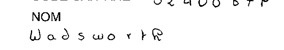

Clean interpretation :  WODSWORH®
--------------------
True text :  WADSWORRE
--------------------
NW comparison :  
 WODSWORH® 
 WADSWORRE
--------------------


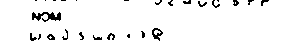

Clean interpretation :  SU U¥MN EEE WADLSYEA SRE
--------------------
True text :  WADSWORRE
--------------------
NW comparison :  
 SU U¥MN EEE WADLSYEA SRE 
 ------------WAD-S--WORRE
--------------------


In [21]:
id = 70
a, b, a1, b1 = compare_results(df3, id)

# Perturbers

A Perturber object is able to "translate" nchars in nchars. Note that given some bugs I could not solve, each Perturber can **ONLY BE FITTED ONCE**.

## BasePerturber

In [22]:
from collections import Counter, defaultdict

class BasePerturber(object):

    def __init__(self, beta, num_rounds, frequency_th=0, seed=None):
        super().__init__()
        ### beta is the probability of an nchar entering the perturbation stage
        ### that is: an nchar is NOT perturbed wp (1-beta) + beta*good[nchar]
        ### if beta == 1, the amount of errors is the same as in the training set 
        self.beta = beta
        self.num_rounds = num_rounds
        self.alignment_algorithm = nw
        self.th = frequency_th
        self.parents = set()
        self.children = set()
        self.allchars = set()
        self.seed = seed
        self.perturbations = defaultdict(lambda: Counter())
        self.__type__ = f'BasePerturber_{self.th}'

    # FITTING FUNCTIONS

    def _find_every_bichar(self):
        """
        Builds:
            - self.parents : set of nchars which have perturbations associated
            - self.children : set of nchars that are perturbations of a parent
            - self.allchars : the union of the two
        """

        self.parents |= set(self.perturbations.keys()) 
        self.children |= set().union(*[set(self.perturbations[c].keys()) for c in self.parents])
        self.allchars |= self.parents.union(self.children)

    def _build_bichar_index(self):
        """
        Builds an index to map a bichar into an int
        If the indices already exist, update them with new keys instead, in order
        to ensure that the incides will be the same when cross validating the 
        Perturber
        """

        # If they already exist, update them instead
        try:
            self.nch2idx
        except:
            self.nch2idx = defaultdict(lambda: None, 
                                        {k : i for (i, k) in enumerate(self.allchars)})
            self.idx2nch = defaultdict(lambda: None, 
                                        {i : k for (i, k) in enumerate(self.allchars)})
            self.par2idx = defaultdict(lambda: None, 
                                        {k : i for (i, k) in enumerate(self.parents)})
            self.idx2par = defaultdict(lambda: None, 
                                        {i : k for (i, k) in enumerate(self.parents)})
        else:
            self.nch2idx.update({k : i for (i, k) in enumerate(self.allchars) 
                                       if k not in self.nch2idx.keys()})
            self.idx2nch.update({i : k for (i, k) in enumerate(self.allchars) 
                                       if i not in self.idx2nch.keys()})
            self.par2idx.update({k : i for (i, k) in enumerate(self.parents) 
                                       if k not in self.par2idx.keys()})
            self.idx2par.update({i : k for (i, k) in enumerate(self.parents) 
                                       if i not in self.idx2par.keys()})

    def _filter_unfrequent_parents(self):
        """
        Filter nchars that appear less than self.th times
        """
        self.unfiltered_parents = self.parents.copy()
        self.unfiltered_perturbations = self.perturbations.copy()
        self.unfiltered_p = self.p.copy()
        self.unfiltered_s = self.s.copy()
        
        self.parents = {nchar for nchar in self.parents 
                              if self.s[nchar] >= self.th}
        self.children = set().union(*[set(self.perturbations[c].keys()) for c in self.parents])
        self.allchars = self.parents | self.children
        for nchar in self.unfiltered_parents - self.parents:
                del self.perturbations[nchar]
                del self.p[nchar]
                del self.s[nchar]

    def _vectorize_dict(self, d, normalize=True):
        """
        Transforms a dicionary into an array using self.nch2idx
        """

        arr = np.zeros(len(self.nch2idx))
        for k, v in d.items():
            if self.nch2idx[k] is not None:
                arr[self.nch2idx[k]] = v
        return arr / arr.sum() if normalize else arr

    def _vectorize_parents(self):
        """
        Vectorizes all of the parents{}
        """

        self.vecpars = np.zeros((len(self.parents), len(self.allchars)))
        for nchar in self.parents:
            self.vecpars[self.par2idx[nchar]] = self._vectorize_dict(self.perturbations[nchar])

    def _interpolate_child(self, nchar, verbose=False):
        """
        Assign a perturbation dictionary to dead ends in the perturbation graph
        eg: if the graph is 'AA' -> 'A ' <- 'AO', how does the Perturber assign
        exit edges from 'A ' ?
        The default one is a selfloop
        """

        if nchar in self.parents:
            pass
        else:
            self.perturbations[nchar] = Counter({nchar : 1})

    def _interpolate_parent(self, nchar, verbose=False):
        """
        Changes the perturbation dictionary of a parent nchar
        """
        pass

    def _interpolate(self, verbose=False):
        """
        Applies approximation to both parents and children
        """

        for nchar in self.allchars:
            if nchar in self.children.difference(self.parents):
                self._interpolate_child(nchar)
            if nchar in self.parents:
                self._interpolate_parent(nchar)

    def _ps(self):
        """
        self.p[nchar] : Probability of perturbing nchar
        self.s[nchar] : Support (number of occurrences of nchar in true documents)
        """

        self.p = Counter()
        self.s = Counter()
        for nchar, occ_count in self.perturbations.items():
            bad = sum(occ for (nch, occ) in occ_count.items() if nch != nchar) 
            good = occ_count[nchar]
            tot = bad + good

            try:
                self.p[nchar] = bad / tot
            except:
                pass
            else:
                self.s[nchar] = tot

    def fit(self, x, y):
        """
        Basic fitting: x and y are aligned, '-' (placeholder chars output from 
        nw) are removed. This allows to identify when a char becomes a bichar
        and viceversa (eg: 'A-' -> 'A ' is translated to 'A' -> 'A ' and
        'A ' -> 'A-' becomes 'A ' -> 'A').
        self.perturbations is built in the format
            {nchar : {perturbed : num_occurrences}}

        """

        for t in zip(x, y):
            # true and scan have equal length
            true, scan = self.alignment_algorithm(t[0], t[1])

            for i in range(len(true)):                
                self.perturbations[true[i]][scan[i]] += 1 
                if i < len(true)-1:
                    self.perturbations[true[i:i+2]][scan[i:i+2]] += 1

        # deal with '-X' and 'X-' in the keys
        tbm1 = {nchar.strip('-') : occ_count 
                for (nchar, occ_count)in self.perturbations.items() 
                if re.match('.-', nchar)}
        tbm2 = {nchar.strip('-') : occ_count 
                for (nchar, occ_count)in self.perturbations.items() 
                if re.match('-.', nchar)}
        tbm1 = defaultdict(lambda: Counter(), tbm1)
        tbm2 = defaultdict(lambda: Counter(), tbm2)

        for nchar in self.perturbations.keys():
            # sum of Counter objects
            self.perturbations[nchar] += tbm1[nchar] + tbm2[nchar]

        # deal with '-X', 'X-' in the keys of the inner Counter
        for nchar in self.perturbations.keys():
            tbm3 = {nchar.strip('-') : occ_count 
                for (nchar, occ_count)in self.perturbations[nchar].items() 
                if re.match('-.', nchar)}
            tbm4 = {nchar.strip('-') : occ_count 
                for (nchar, occ_count)in self.perturbations[nchar].items() 
                if re.match('.-', nchar)}
            tbm3 = Counter(tbm3)
            tbm4 = Counter(tbm4)

            self.perturbations[nchar] += tbm3 + tbm4

        # delete entries with '-'
        self.perturbations = defaultdict(
            lambda: Counter(),
            {
                k : Counter({
                    k2 : v for (k2, v) in counter.items() if '-' not in k2
                }) 
                for (k, counter) in self.perturbations.items() if '-' not in k
            })

        # run approximations and other stuff
        self._ps()     
        self._find_every_bichar()
        self._filter_unfrequent_parents()
        self._build_bichar_index()
        self._vectorize_parents()

    # TRANSFORMING FUNCTIONS

    def _perprob(self, ls, with_beta=True, with_rounds=True):
        """
        Probability of perturbing a list of nchars across multiple rounds. 
        Rounds of perturbation are independent, ls is supposed to not change
        in all rounds (as the perturbation probability is the 1-complement of 
        the probability of not having perturbations)
        """
        # assume the text stays the same during all rounds
        b = self.beta if with_beta else 1
        nr = self.num_rounds if with_rounds else 1
        return 1 - np.prod([1-self.p[nchar]*b for nchar in ls])**nr

    def _all_splits(self, t):
        """
        All the splits of a trichar
        """

        if len(t) == 1:
            return (t, )
        elif len(t) == 2:
            return (t[0], t[1]), (t, )
        elif len(t) == 3:
            return (t[0], t[1], t[2]), (t[:2], t[2]), (t[0], t[1:])
        else:
            raise ValueError(f"""Argument t="{t}" has length {len(t)} but should
                                 have length in [1,2,3]""") 

    def _optimal_trichar_split(self, trichar : string, verbose=False):
        """
        Split a trichar to maximize the probaility of error
        """

        c = Counter({x : self._perprob(x) for x in self._all_splits(trichar)})
        return c.most_common(1)[0]

    def _split(self, text : string, verbose=False):
        """
        Split a document in unichars and bichars in order to maximize the 
        probability of perturbation. 
        As the total number of possible splits for a document of length N is the 
        N-th Fibonacci number (exponential complexity), the solution is found
        with a greedy approach: 
            take the first trichar
            find its optimal partition in unichars and bichars
            save all but the last element of the split in the output
            keep the last element as the start of the next trichar
            iterate until the optimal split 'spl' is composed of just one element
                eg: spl = ('RA') or spl = ('A')
        """

        i = 0
        splits = []
        
        while True:
            if i >= len(text):
                break

            tri = text[i:i+3]

            spl = self._optimal_trichar_split(tri, verbose=verbose)[0]
            if len(spl) == 1:
                splits.extend(spl[0])
                break
            else:
                splits.extend(spl[:-1])
            i += (3-len(spl[-1]))

        self.splits = splits
        return splits

    def _perturb(self, nchar, verbose=False):
        """
        Returns a random element in the perturbations of 'nchar', according to
        the number of occurrences
        """
        
        nchs = list(self.perturbations[nchar].keys())
        occs = np.array(list(self.perturbations[nchar].values()))
        # np.random.seed(self.seed)
        return np.random.choice(nchs, p=occs/occs.sum())           

    def _add_to_perturbations(self, text):
        for i in range(len(text)):
            if text[i] not in self.perturbations.keys():
                self.perturbations[text[i]][text[i]] += 1
            if i < len(text)-1: 
                if text[i:i+1] not in self.perturbations.keys():
                    self.perturbations[text[i:i+2]][text[i:i+2]] += 1

    def _transform_text(self, text, verbose=False):
        """
        Split a text into a list of bichars and unichars with self._split, 
        perturb each element in the list, join the results
        """

        if len(text) == 0:
            return text

        self._add_to_perturbations(text)

        perturbed_text = text
        for _ in range(self.num_rounds):
            perturbed = []
            for nchar in self._split(perturbed_text, verbose=verbose):
                # np.random.seed(self.seed)
                if np.random.random() < self.beta:
                    perturbed.append(self._perturb(nchar, verbose=verbose))      
                else:
                    perturbed.append(nchar)
            perturbed_text = ''.join(perturbed)
        return perturbed_text

    def transform(self, x, verbose=False):
        """
        Applies self._transform_text to an iterator of strings
        """
        perturbed_texts = []
        for text in x:
            perturbed_texts.append(self._transform_text(text, verbose=verbose))
        return perturbed_texts

    # OTHER FUNCTIONS

    def expected_num_mistakes(self, text, with_beta=True, with_rounds=False, 
                              verbose=False):
        """
        Expected number of mistaken nchars in a SINGLE round of perturbations

        """
        b = self.beta if with_beta else 1
        nr = self.num_rounds if with_rounds else 1
        a = np.array([b*self.p[nchar] for nchar in self._split(text, verbose=verbose)])
        p = a.sum() / len(a)
        return len(a)*p

## RandomPerturber

In [23]:
from itertools import product

class RandomPerturber(BasePerturber):

    def __init__(self, alphabet=string.ascii_letters+' ', **kwargs):
        super().__init__(**kwargs)
        self.alphabet = list(alphabet)
        self.__type__ = 'RandomPerturber'

    def fit(self, x, y):

        bichars = [a+b for (a,b) in product(self.alphabet, self.alphabet)]

        rnd_counter = Counter({c : 1 for c in self.alphabet + bichars})

        self.perturbations = defaultdict(lambda: rnd_counter)
        for doc in x:
            for i in range(len(doc)):
                uc = doc[i]
                self.perturbations[uc] = rnd_counter
                if uc not in bichars: 
                    bichars.append(uc)
                if i < len(doc)-1:
                    bc = doc[i:i+2]
                    self.perturbations[bc] = rnd_counter
                    if bc not in bichars:
                        bichars.append(bc)

        # self._ps()
        # self._find_every_bichar()
        # self._filter_unfrequent_parents()
        # self._build_bichar_index()

    def _split(self, text, verbose=False):
        i = 0
        splits = []     
        while True:
            if i >= len(text):
                break

            rnd = np.random.choice((1,2))
            splits.append(text[i: i+rnd+1])

            i += rnd

        self.splits = splits
        return splits

## ClusterPerturber

In [24]:
import numpy as np 

from sklearn.cluster import DBSCAN, AgglomerativeClustering
from numpy.linalg import norm

# Continuous overlapping index: https://www.frontiersin.org/articles/10.3389/fpsyg.2019.01089/full
@njit
def continuous_overlapping_distance(v1 : np.ndarray, v2 : np.ndarray):
    v1 /= v1.sum()
    v2 /= v2.sum()
    return 1 - np.array([min(v1[t], v2[t]) for t in range(len(v1))]).sum()

@njit
def cosine_distance(v1 : np.ndarray, v2 : np.ndarray):
    return 1 - np.dot(v1, v2) / (norm(v1)*norm(v2))

class ClusterPerturber(BasePerturber):

    def __init__(self, metric, **kwargs):
        super().__init__(**kwargs)
        self.metric = metric
        self.clust = None
        self.clustering = None

    def _cluster_parents(self):
        self.clustering.fit(self.vecpars)

    def _compute_distances_matrix(self):
        indexes = np.arange(len(self.vecpars))
        self.distances_matrix = np.zeros((len(indexes), len(indexes)))

        for i, vi in enumerate(self.vecpars):
            for j, vj in enumerate(self.vecpars):
                self.distances_matrix[i, j] = self.metric(vi, vj)

        self.distances_matrix[self.distances_matrix < 0] = 0.

    def _approximate_child(self, nchar):
        pass

    def _approximate_parent(self, nchar):
        # Add to the parent the average perturbations of its cluster
        for nchar in self.parents:
            idx = self.par2idx[nchar]

    def fit(self, x, y):
        super().fit(x, y)
        # self._vectorize_parents()
        # self._cluster_parents()
        # self._approximate()
        self._compute_distances_matrix()

## AgglomerativePerturber

In [25]:
class AgglomerativePerturber(ClusterPerturber):

    def __init__(self, n_clusters=None, n_clusters_range=range(2, 36), **kwargs):
        super().__init__(**kwargs)
        self.clust_algo = AgglomerativeClustering
        self.n_clusters = n_clusters
        self.n_clusters_range = list(n_clusters_range)
        self.n_clusters_range_input = self.n_clusters_range.copy()
        if self.n_clusters is not None:
            self.clustering = self.clust_algo(affinity='precomputed', 
                                              linkage='single', n_clusters=self.n_clusters)
        self.__type__ = f'AgglomerativePerturber_{self.th}'

    def _tune_clustering(self):

        # print(self.distances_matrix.shape)

        scores = []
        for (i, k) in enumerate(self.n_clusters_range):
            ac = self.clust_algo(affinity='precomputed', linkage='single', 
                            distance_threshold=None, n_clusters=k)
            ac.fit(self.distances_matrix)
            try:
                s = silhouette_score(self.vecpars, ac.labels_, metric=self.metric)
            except Exception as e:
                print(f"""Iteration skipped at {k} clusters due to {e}""")
                self.n_clusters_range.pop(i)
                continue

            # protection from extreme values
            if s > 1 or s < -1:
                print(f"""Iteration skipped at {k} clusters due to extreme values""")
                self.n_clusters_range.pop(i)
                continue

            scores.append(s)

        if len(scores) == 0:
            self.n_clusters = None
            return

        # print(i, k, scores, self.n_clusters_range)

        # the bets number of cluster is the max one that is one std deviation
        # from the argmax
        mm = max(scores)
        ss = np.std(scores)
        for nbest, sc in enumerate(scores[::-1]):
            if sc >= mm-ss:
                break

        self.n_clusters = self.n_clusters_range[len(scores)-1 - nbest]
        self.silhouette_scores = scores
       
    def _fit_clustering(self):
         self.clustering = self.clust_algo(affinity='precomputed', linkage='single',
                                          n_clusters=self.n_clusters)
         self.clustering.fit(self.distances_matrix)

    def plot_scores(self):
        plt.plot(self.n_clusters_range, self.silhouette_scores, c='b')
        plt.axvline(self.n_clusters, c='r', ls=':')
        plt.title('Agglomerative clustering')
        plt.xlabel('number of clusters')
        plt.ylabel('silhouette score')
        plt.show()

    def _approximate_parent(self, nchar, centroid=None):
        # find its vector representation
        v = self.vecpars[self.par2idx[nchar]]

        # find the other parents in the same cluster
        if centroid is None:
            lbl = self.clustering.labels_[self.par2idx[nchar]]
            cluster = self.vecpars[self.clustering.labels_ == lbl] 
            centroid = cluster.mean(axis=0)
        # compute the similarity with the centroid
        sim = 1 - self.metric(v, centroid)
        # now change the vector and perturbations accordingly
        # note that the total sum of perturbations is unchanged (to ensure the 
        # support stays the same)
        v = (1-sim)*v + sim*centroid
        self.perturbations[nchar] = Counter({
            self.idx2nch[id] : val*self.s[nchar] for (id, val) in enumerate(v)
        })


    def _approximate(self):
        for lbl in set(self.clustering.labels_):
            if lbl == -1:
                continue
            cluster = self.vecpars[self.clustering.labels_ == lbl]
            centroid = cluster.mean(axis=0)
            cluster_nchar = [nchar for nchar in self.parents
                             if self.clustering.labels_[self.par2idx[nchar]] == lbl]
            for nchar in cluster_nchar:
                self._approximate_parent(nchar, centroid=centroid)        

    def fit(self, x, y):
        super().fit(x, y)

        self._compute_distances_matrix()
        if self.n_clusters is None:
            self._tune_clustering()
        if self.n_clusters is None:
            print('No valid clusters found')
            return
        self._fit_clustering()
        self._approximate()

## DBSCANPerturber

In [26]:
class DBSCANPerturber(ClusterPerturber):

    def __init__(self, eps=None, eps_range=np.linspace(0.001, 1-0.001, 20), min_samples=2, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.eps_range = list(eps_range)
        self.eps_range_input = self.eps_range.copy()
        self.min_samples = min_samples
        self.clust_algo = DBSCAN
        if eps is not None:
            self.clustering = self.clust_algo(metric='precomputed', eps=self.eps, 
                                              min_samples=self.min_samples)
        self.__type__ = f'DBSCANPerturber_{self.th}'


    def _tune_clustering(self):
        scores = []
        for (i, eps) in enumerate(self.eps_range):
            ac = self.clust_algo(metric='precomputed', eps=eps, 
                                 min_samples=self.min_samples)
            ac.fit(self.distances_matrix)

            labels = ac.labels_
            not_noise = [l for (l, lab) in enumerate(labels) if lab != -1]
            x = self.vecpars[not_noise]
            not_noisy_labels = [lab for (l, lab) in enumerate(labels) if lab != -1]

            try:
                s = silhouette_score(x, not_noisy_labels, metric=self.metric)
            except Exception as e:
                # print(f'Iteration sikpped at eps = {eps} due to: {e}')
                self.eps_range.pop(i)
                continue

            # protection from extreme values
            if s > 1 or s < -1:
                # print(f'Iteration skipped at eps = {eps} clusters due to: unvalid score.')
                self.eps_range.pop(i)
                continue

            scores.append(s)

        if len(scores) == 0:
            self.eps = None
            return

        # the best number of cluster is the max one that is one std deviation
        # from the argmax
        mm = max(scores)
        ss = np.std(scores)
        for nbest, sc in enumerate(scores[::-1]):
            if sc >= mm-ss:
                break

        self.eps = self.eps_range[len(scores)-1 - nbest]
        self.silhouette_scores = scores
       
    def _fit_clustering(self):
         self.clustering = self.clust_algo(metric='precomputed', eps=self.eps,
                                          min_samples=self.min_samples)
         self.clustering.fit(self.distances_matrix)

    def plot_scores(self):
        plt.plot(self.eps_range, self.silhouette_scores, c='b')
        plt.axvline(self.eps, c='r', ls=':')
        plt.title('DBSCAN clustering')
        plt.xlabel('minimum distance')
        plt.ylabel('silhouette score')
        plt.show()

    def _approximate_parent(self, nchar, centroid=None):
        # find its vector representation
        v = self.vecpars[self.par2idx[nchar]]

        # find the other parents in the same cluster
        if centroid is None:
            lbl = self.clustering.labels_[self.par2idx[nchar]]
            cluster = self.vecpars[self.clustering.labels_ == lbl] 
            centroid = cluster.mean(axis=0)
        # compute the similarity with the centroid
        sim = 1 - self.metric(v, centroid)
        # now change the vector and perturbations accordingly
        # note that the total sum of perturbations is unchanged (to ensure the 
        # support stays the same)
        v = (1-sim)*v + sim*centroid
        self.perturbations[nchar] = Counter({
            self.idx2nch[id] : val*self.s[nchar] for (id, val) in enumerate(v)
        })


    def _approximate(self):
        for lbl in set(self.clustering.labels_):
            if lbl == -1:
                continue
            cluster = self.vecpars[self.clustering.labels_ == lbl]
            centroid = cluster.mean(axis=0)
            cluster_nchar = [nchar for nchar in self.parents
                             if self.clustering.labels_[self.par2idx[nchar]] == lbl]
            for nchar in cluster_nchar:
                self._approximate_parent(nchar, centroid=centroid)        

    def fit(self, x, y):
        # needed for repeated fits
        self.eps_range = self.eps_range_input.copy()
        super().fit(x, y)
        self._compute_distances_matrix()
        if self.eps is None:
            self._tune_clustering()
        if self.eps is None:
            print('No valid clusters found')
            return
        self._fit_clustering()
        self._approximate()

## GraphPerturber

In [27]:
import networkx as nx

class GraphPerturber(BasePerturber):

    def __init__(self, metric, tune_on, eps=None, 
                 eps_range=np.linspace(0.001, 1-0.001, 20), **kwargs):
        super().__init__(**kwargs)
        self.metric = metric
        self.eps_range_input = list(eps_range)
        self.eps_range = list(eps_range)
        self.eps = eps
        try:
            assert tune_on in {'silhouette', 'num_clusters'}
        except:
            raise ValueError(f'{tune_on} is an invalid parameter for tune_on. use "silhouette" or "num_clusters" to maximize the silhouette score or the number of clusters')
        self.tune_on = tune_on
        self.__type__ = f'GraphPerturber_{tune_on}_{self.th}'

    def _compute_distances_matrix(self):
        indexes = np.arange(len(self.vecpars))
        self.distances_matrix = np.zeros((len(indexes), len(indexes)))

        for i, vi in enumerate(self.vecpars):
            for j, vj in enumerate(self.vecpars):

                # print(self.idx2par[i], i, vi)
                # print(self.idx2par[j], j, vj)
                # print(self.metric(vi, vj))
                # print('-'*20)

                self.distances_matrix[i, j] = self.metric(vi, vj)

        self.distances_matrix[self.distances_matrix < 0] = 0.

    def _build_parents_graph(self):
        self.Gpar = nx.Graph()
        self.Gpar.add_nodes_from(self.parents)

        edges = []
        for p1, p2 in product(self.parents, repeat=2):
            # compare pairs only once
            if p1 <= p2:
                id1 = self.par2idx[p1]
                id2 = self.par2idx[p2]
                edges.append((p1, p2, self.distances_matrix[id1, id2]))

        self.Gpar.add_weighted_edges_from(edges)

    def _build_graphs(self):
        self._build_parents_graph()

    def _tune_clustering(self):        

        scores = []
        for (i, eps) in enumerate(self.eps_range):
            # for (u, v, prop) in self.Gpar.edges(data=True):
            #     print(u, v, prop)

            # train
            edges = [(u, v) for (u, v, prop) in self.Gpar.edges(data=True) 
                            if prop['weight'] <= eps]

            # find clusters (cc with more than one element)
            ccs = [a for a in nx.connected_components(self.Gpar.edge_subgraph(edges)) 
                     if len(a) > 1]

            # nchars that appear alone are defaulted to label -1
            # labels = defaultdict(
            #     lambda: -1,
            #     {{nchar : lbl for nchar in cluster} for cluster, lbl in enumerate(ccs)}
            # )

            labels = [-1]*len(self.parents)
            for label, cluster in enumerate(ccs):
                for nchar in cluster:
                    labels[self.par2idx[nchar]] = label

            # filter out noise (with label -1)
            # the indices for which labels == -1
            not_noise = [l for (l, lab) in enumerate(labels) if lab != -1]
            x = self.vecpars[not_noise]
            not_noisy_labels = [lab for (l, lab) in enumerate(labels) if lab != -1]

            if self.tune_on == 'silhouette':

                try:
                    s = silhouette_score(x, not_noisy_labels, metric=self.metric)
                except Exception as e:
                    print(f'Iteration skipped at eps = {eps} due to: {e}')
                    self.eps_range.pop(i)
                    continue

                # protection from extreme values
                if s > 1 or s < -1:
                    print(f'Iteration skipped at eps = {eps} clusters due to: unvalid score.')
                    self.eps_range.pop(i)
                    continue
                    
            elif self.tune_on == 'num_clusters':
                s = len(set(not_noisy_labels))

            scores.append(s)

        if len(scores) == 0:
            self.eps = None
            return

        if self.tune_on == 'silhouette':
            # the bets number of cluster is the max one that is one std deviation
            # from the argmax
            mm = max(scores)
            ss = np.std(scores)
            for nbest, sc in enumerate(scores[::-1]):
                if sc >= mm-ss:
                    break

            self.eps = self.eps_range[len(scores)-1 - nbest]
            self.scores = scores
        elif self.tune_on == 'num_clusters':
            self.eps = self.eps_range[np.array(scores).argmax()]
            self.scores = scores

    def plot_scores(self):
        plt.plot(self.eps_range, self.scores, c='b')
        plt.axvline(self.eps, c='r', ls=':')
        plt.title('Graph clustering')
        plt.xlabel('minimum distance')
        if tune_on == 'silhouette':
            plt.ylabel('silhouette score')
        elif tune_on == 'num_clusters':
            plt.ylabel('number of clusters')
        plt.show()

    def _fit_clustering(self):

        edges = [(u, v) for (u, v, prop) in self.Gpar.edges(data=True) 
                            if prop['weight'] <= self.eps]

        # find clusters (cc with more than one element)
        ccs = [a for a in nx.connected_components(self.Gpar.edge_subgraph(edges)) 
                if len(a) > 1]

        # nchars that appear alone are defaulted to label -1
        # labels = defaultdict(
        #     lambda: -1,
        #     {{nchar : lbl for nchar in cluster} for cluster, lbl in enumerate(ccs)}
        # )

        labels = [-1]*len(self.parents)
        for label, cluster in enumerate(ccs):
            for nchar in cluster:
                labels[self.par2idx[nchar]] = label

        self.labels_ = np.array(labels)

    def _approximate_parent(self, nchar, centroid=None):
        # find its vector representation
        v = self.vecpars[self.par2idx[nchar]]

        # find the other parents in the same cluster
        if centroid is None:
            lbl = self.labels_[self.par2idx[nchar]]
            cluster = self.vecpars[self.labels_ == lbl] 
            centroid = cluster.mean(axis=0)

        # compute the similarity with the centroid
        sim = 1 - self.metric(v, centroid)
        # now change the vector and perturbations accordingly
        # note that the total sum of perturbations is unchanged (to ensure the 
        # support stays the same)
        v = (1-sim)*v + sim*centroid
        self.perturbations[nchar] = Counter({
            self.idx2nch[id] : val*self.s[nchar] for (id, val) in enumerate(v)
        })

    def _build_clustersdict(self):
        self.clustersdict = {
            lbl : {nch for nch in np.where(self.labels_ == lbl)[0]} 
            for lbl in self.labels
        }            


    def _approximate(self):
        for lbl in set(self.labels_):
            if lbl == -1:
                continue
            cluster = self.vecpars[self.labels_ == lbl]

            centroid = cluster.mean(axis=0)
            cluster_nchar = [nchar for nchar in self.parents
                             if self.labels_[self.par2idx[nchar]] == lbl]
            for nchar in cluster_nchar:
                self._approximate_parent(nchar, centroid=centroid)       

    def fit(self, x, y):
        # needed for repeated iterations of fit
        self.eps_range = self.eps_range_input.copy()

        super().fit(x, y)
        self._compute_distances_matrix()
        self._build_graphs()
        if self.eps is None:
            self._tune_clustering()
        if self.eps is None:
            print('No valid clusters found')
            return
        self._fit_clustering()
        self._approximate()

# Comparing different perturbers


In [28]:
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score

def to_array(d1, d2):
    keys = set(d1.keys()).union(set(d2.keys()))
    idx = defaultdict(lambda: None, {k : i for (i, k) in enumerate(keys)})

    arr1, arr2 = np.zeros((2, len(keys)))
    for k in keys:
        try:
            arr1[idx[k]] += d1[k]
        except KeyError: 
            pass
        try:
            arr2[idx[k]] += d2[k]
        except KeyError:
            pass

    return arr1, arr2, idx

def cod(d1, d2):
    a1, a2, _ = to_array(d1, d2) 
    a1 /= a1.sum()
    a2 /= a2.sum()
    return 1 - np.sum([min(x, y) for (x,y) in zip(a1, a2)])

In [29]:
beta = 1
num_rounds = 1
metric = continuous_overlapping_distance
tune_on = 'num_clusters'
n_clusters_range = range(1,20, 2)
eps_range = np.linspace(0.001, 1-0.001, 10)
thetas = [10]

P, RP, AP, DP, GPn, GPs = ({} for _ in range(6))

for th in thetas:
    P[th] = BasePerturber(beta=beta, num_rounds=num_rounds, frequency_th=th)
    RP[th] = RandomPerturber(beta=beta, num_rounds=num_rounds, frequency_th=th)
    AP[th] = AgglomerativePerturber(beta=beta, num_rounds=num_rounds, metric=metric, n_clusters_range=n_clusters_range, frequency_th=th)
    DP[th] = DBSCANPerturber(beta=beta, num_rounds=num_rounds, metric=metric, eps_range=eps_range, frequency_th=th)
    GPn[th] = GraphPerturber(beta=beta, num_rounds=num_rounds, metric=metric, tune_on='num_clusters', eps_range=eps_range, frequency_th=th)
    GPs[th] = GraphPerturber(beta=beta, num_rounds=num_rounds, metric=metric, tune_on='silhouette', eps_range=eps_range, frequency_th=th)


In [30]:
pert = [P, RP, AP, DP, GPn, GPs]
eval = defaultdict(lambda: [])
mistakes = defaultdict(lambda: [])
errors = {}

K = 5
ids = df_train.index
fresh = ids
fold_size = len(ids) // K
distances = []
for k in tqdm(range(K)):

    for th in thetas:
        P[th] = BasePerturber(beta=beta, num_rounds=num_rounds, frequency_th=th)
        RP[th] = RandomPerturber(beta=beta, num_rounds=num_rounds, frequency_th=th)
        AP[th] = AgglomerativePerturber(beta=beta, num_rounds=num_rounds, metric=metric, n_clusters_range=n_clusters_range, frequency_th=th)
        DP[th] = DBSCANPerturber(beta=beta, num_rounds=num_rounds, metric=metric, eps_range=eps_range, frequency_th=th)
        GPn[th] = GraphPerturber(beta=beta, num_rounds=num_rounds, metric=metric, tune_on='num_clusters', eps_range=eps_range, frequency_th=th)
        GPs[th] = GraphPerturber(beta=beta, num_rounds=num_rounds, metric=metric, tune_on='silhouette', eps_range=eps_range, frequency_th=th)

    np.random.seed(1444)
    test = list(np.random.choice(fresh, fold_size))
    train = list(set(ids) - set(test))
    fresh = list(set(fresh) - set(test))

    x_train = df_train.identity.loc[train]
    y_train = df_train.ocrClean.loc[train]

    df_val = df_train.loc[test]
    x_test = df_val.identity
    y_test = df_val.ocrClean

    # perturb everything
    
    for pe in tqdm(pert):
        for th in tqdm(thetas):
            typename = pe[th].__type__
            pe[th].fit(x_train, y_train)
            df_val[typename] = pe[th].transform(x_test)

            Pground = BasePerturber(beta=beta, num_rounds=num_rounds)
            Peval = BasePerturber(beta=beta, num_rounds=num_rounds)
            Pground.fit(x_test, y_test)
            Peval.fit(x_test, df_val[typename])
            cods = {nchar : cod(Pground.perturbations[nchar], Peval.perturbations[nchar]) for nchar in Pground.parents & Peval.parents}
            cods2 = np.array(list(cods.values()))
            eval[typename].append((cods2.mean(), cods))

            df_val[typename + '_mistakes'] = df_val.identity.apply(lambda text : Peval.expected_num_mistakes(text))
            df_val[typename + '_true_mistakes'] = df_val.identity.apply(lambda text : Pground.expected_num_mistakes(text))
            df_val[typename + '_diff_mistakes'] = df_val[typename + '_mistakes'] - df_val[typename + '_true_mistakes']
            mistakes[typename].append(df_val[typename + '_diff_mistakes'].mean())

mists = {}
errors = {}
for typename, err in tqdm(eval.items()):
    errors[typename] = (np.array([a[0] for a in err]).mean(), np.array([a[0] for a in err]).std())
    mists[typename] = (np.array(mistakes[typename]).mean(), np.array(mistakes[typename]).std())

KeyboardInterrupt: ignored

In [ ]:
errors, mists

# Tuning of ClusterPerturber and GraphPerturber


These are the **embrions** of the `_tune_clustering` methods of the ClusterPerturbers. They are here scorporated to show the fundamental process of parameter tuning and to produce the graphs shown in the report. 

## Agglomerative perturber

In [31]:
CP = ClusterPerturber(beta=1, num_rounds=1, metric=continuous_overlapping_distance, frequency_th=0)
CP.fit(df3.identity, df3.ocrClean)

In [32]:
from sklearn.metrics import silhouette_score

x = CP.vecpars
M = CP.distances_matrix
# prevent underflow that appears for more than 37 clusters
# the method incorporated in the AgglomerativePerturber class can deal with 
# invalid values 
k_range = range(2, 36)

scores4 = []
for k in tqdm(k_range):
    ac = AgglomerativeClustering(affinity='precomputed', linkage='single', distance_threshold=None, n_clusters=k)
    ac.fit(M)
    scores4.append(silhouette_score(x, ac.labels_, metric=continuous_overlapping_distance))

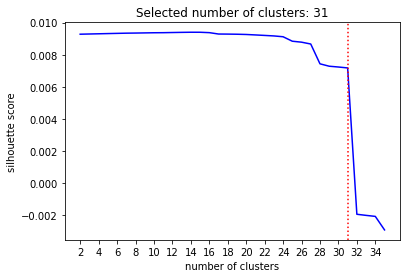

In [33]:
import matplotlib.pyplot as plt

mm = max(scores4)
ss = np.std(scores4)
for best, sc in enumerate(scores4[::-1]):
    if sc > mm-ss:
        break

plt.plot(k_range, scores4, c='b')
plt.xticks(k_range[::2])
plt.axvline(k_range[len(scores4)-1 - best], c='r', ls=':')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title(f'Selected number of clusters: {k_range[len(scores4)-1 - best]}')

plt.show()

What we see here is that performance is already bad, then worsening fast with more than a number of clusters. 

## DBSCAN Perturber

In [34]:
from time import time

In [35]:
CP = ClusterPerturber(beta=1, num_rounds=1, metric=continuous_overlapping_distance, frequency_th=0)
CP.fit(df3.identity, df3.ocrClean)

In [59]:
start = time()

x = CP.vecpars
M = CP.distances_matrix

eps_range = list(np.linspace(0.001, 1-0.001, 21))
i = 0
scores = []
while i < len(eps_range):
    eps = eps_range[i]
    ds = DBSCAN(metric='precomputed', eps=eps, min_samples=2)
    ds.fit(M)
    try:
        scores.append(silhouette_score(x, ds.labels_, metric=continuous_overlapping_distance))
    except Exception as e: 
        print(f'{eps} not valid because of {e}')
        eps_range.pop(i)
        continue

    i += 1

end = time()-start
print(end)

0.001 not valid because of Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
0.0509 not valid because of Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
87.32255697250366


Text(0.5, 1.0, 'Selected epsilon: 0.7494999999999999')

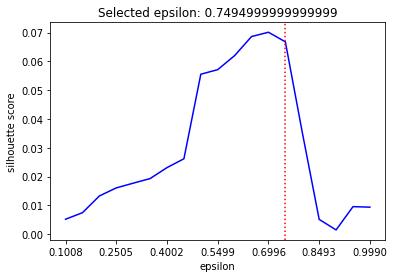

In [61]:
mm = max(scores)
ss = np.std(scores)
for best, sc in enumerate(scores[::-1]):
    if sc > mm-ss:
        break

plt.plot(eps_range, scores, c='b')
plt.xticks(eps_range[::3])
plt.axvline(eps_range[len(scores)-1 - best], c='r', ls=':')
plt.xlabel('epsilon')
plt.ylabel('silhouette score')
plt.title(f'Selected epsilon: {eps_range[len(scores)-1 - best]}')

## Graph Perturber

### Silhouette tuning

In [41]:
GP = GraphPerturber(beta=beta, num_rounds=num_rounds, metric=metric, 
                    tune_on='num_clusters', eps=1, eps_range=eps_range)
GP.fit(df3.identity, df3.ocrClean)

In [ ]:
start = time()

M = GP.distances_matrix
simG = GP.Gpar

eps_range = list(np.linspace(0.001, 1-0.001, 21))
i = 0
scores2 = []
while i < len(eps_range):

    eps = eps_range[i]
    xx = x
    # train
    edges = [(u, v) for (u, v, prop) in simG.edges(data=True) if prop['weight'] <= eps]

    # find clusters (cc with more than one element)
    b = []
    for a in nx.connected_components(simG.edge_subgraph(edges)):
        if len(a) > 1:
            b.append(a)

    # assign a label to each parent (-1 is assigned to noisy nodes)
    labels = [-1]*len(GP.parents)
    for label, a in enumerate(b):
        for nchar in a:
            labels[GP.par2idx[nchar]] = label

    # filter out noise (with label -1)
    # the indices for which labels == -1
    not_noise = [l for (l, lab) in enumerate(labels) if lab != -1]
    xx = x[not_noise]
    labels = [lab for (l, lab) in enumerate(labels) if l in not_noise]

    try:
        scores2.append(silhouette_score(xx, labels, metric=continuous_overlapping_distance))
    except Exception as e: 
        print(f'{eps} not valid because of {e}')
        eps_range.pop(i)
        continue
    i += 1

end = time()-start
print(end)

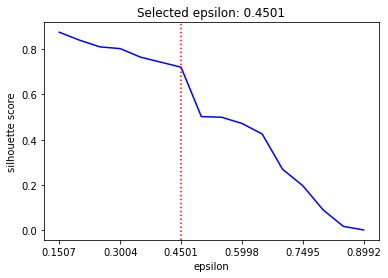

In [58]:
mm = max(scores2)
ss = np.std(scores2)
for best, sc in enumerate(scores2[::-1]):
    if sc > mm-ss:
        break

plt.plot(eps_range, scores2, c='b')
plt.xticks(eps_range[::3])
plt.axvline(eps_range[len(scores2)-1 - best], c='r', ls=':')
plt.xlabel('epsilon')
plt.ylabel('silhouette score')
plt.title(f'Selected epsilon: {eps_range[len(scores2)-1 - best]}')

plt.show()

### num_clusters tuning

In [ ]:
GP = GraphPerturber(beta=beta, num_rounds=num_rounds, metric=metric, 
                    tune_on='num_clusters', eps=1, eps_range=eps_range)
GP.fit(df3.identity, df3.ocrClean)

In [ ]:
from itertools import product

start = time()

M = GP.distances_matrix
simG = GP.Gpar

eps_range = np.linspace(0.001, 1-0.001, 21)

vs = []
for eps in tqdm(eps_range):
    edges = [(u, v) for (u, v, prop) in simG.edges(data=True) if prop['weight'] <= eps]
    b = []
    for a in nx.connected_components(simG.edge_subgraph(edges)):
        if len(a) > 1:
            b.append(a)
    vs.append(len(b))

end = time() - start
print(end)

In [ ]:
best = eps_range[np.argmax(vs)]

plt.plot(eps_range, vs, c='b')
plt.xticks(eps_range[::3])
plt.axvline(best, c='r', ls=':')
plt.xlabel('epsilon')
plt.ylabel('number of clusters')
plt.title(f'Selected epsilon: {best}')

# Study on the COD 

In [ ]:
def plot_levelset(v0, eps, t, n):

    xs, ys, zs, xclose, yclose, zclose, xfar, yfar, zfar = [], [], [], [], [], [], [], [], []
    vecs = []
    dists = []
    euc = []
    dd = []
    ee = []
    for x in tqdm(np.linspace(0, 1, n)):
        for y in np.linspace(0, 1-x, n):
            z = 1-x-y
            v = np.array((x, y, z))

            d = continuous_overlapping_distance(v0, v)
            eu = norm(v0-v)

            if t-eps < d < t+eps:    
                xfar.append(x)
                yfar.append(y)
                zfar.append(z)
                dd.append(d)

            if t-eps < eu < t+eps:
                xclose.append(x)
                yclose.append(y)
                zclose.append(z)
                ee.append(eu)

            else:
                xs.append(x)
                ys.append(y)
                zs.append(z)
                dists.append(d)
                euc.append(eu)

    fig = plt.figure(figsize=(24, 8))

    # subplot 11
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter(xs, ys, zs, c=dists, cmap='afmhot')

    ax.scatter(v0[0], v0[1], v0[2], c='b')
    ax.scatter(1, 0, 0, c='black')
    ax.scatter(0, 1, 0, c='black')
    ax.scatter(0, 0, 1, c='black')                      

    ii = np.linspace(0,1,100)
    ax.scatter(ii, 1-ii, 0, c='black')
    ax.scatter(ii, 0, 1-ii, c='black')                                                                              
    ax.scatter(0, ii, 1-ii, c='black')

    ax.view_init(elev=30., azim=70)

    # subplot 21

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter(xfar, yfar, zfar, c='r')
    ax.scatter(xclose, yclose, zclose, c='g')

    ax.scatter(v0[0], v0[1], v0[2], c='b')
    ax.scatter(1, 0, 0, c='black')
    ax.scatter(0, 1, 0, c='black')
    ax.scatter(0, 0, 1, c='black')

    ii = np.linspace(0,1,100)
    ax.scatter(ii, 1-ii, 0, c='black')
    ax.scatter(ii, 0, 1-ii, c='black')
    ax.scatter(0, ii, 1-ii, c='black')

    ax.view_init(elev=30., azim=70)

    # subplot 12
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter(xclose, yclose, zclose, c='r')
    ax.scatter(xs, ys, zs, c=euc, cmap='afmhot')

    ax.scatter(v0[0], v0[1], v0[2], c='b')
    ax.scatter(1, 0, 0, c='black')
    ax.scatter(0, 1, 0, c='black')
    ax.scatter(0, 0, 1, c='black')

    ii = np.linspace(0,1,100)
    ax.scatter(ii, 1-ii, 0, c='black')
    ax.scatter(ii, 0, 1-ii, c='black')
    ax.scatter(0, ii, 1-ii, c='black')

    ax.view_init(elev=30., azim=70)




In [ ]:
v0 = np.array((1/8, 3/8, 1/2))

eps = 1/1000
t = 1/5
n = 500

plot_levelset(v0, eps, t, n)


# Example of GraphPerturber fitting

In [ ]:
"""
EVERYTHING IS MADE TO BE FIT ONCE. AND ONCE ONLY
"""


true = ['SCANNING']
read = ['SC ANN NINH']
bs = ['E']
rs = ['D']

In [ ]:
%%capture
BB = GraphPerturber(beta=1, num_rounds=1, metric=continuous_overlapping_distance, tune_on='silhouette')
# print(BB.eps_range, BB.eps_range_input)
# BB.fit(true, read)
# BB.perturbations

In [ ]:
%%capture
# print(BB.eps_range, BB.eps_range_input)
BB.fit(bs, rs)
# print(BB.eps_range, BB.eps_range_input)
# BB.perturbations

In [ ]:
BB.fit(dfex.identity, dfex.ocrClean)

In [ ]:
BB.distances_matrix

In [ ]:
Gex = GraphPerturber(beta=1, num_rounds=1, metric=continuous_overlapping_distance, tune_on='silhouette')

In [ ]:
dfex.identity, dfex.ocrClean

# Tutorials

In [ ]:
t1 = 'unimi'
t2 = 'un Im i'
nw(t1, t2)

In [ ]:
Ptest = BasePerturber(beta=1, num_rounds=1)
Ptest.fit([t1], [t2])
Ptest.perturbations

In [ ]:
Ptest.p

In [ ]:
Ptest.s

In [ ]:
Ptest.vecpars[Ptest.par2idx['i']]

In [ ]:
Ptest.nch2idx['I'], Ptest.nch2idx['i'], Ptest.nch2idx[' I'], Ptest.nch2idx[' i']

In [ ]:
fresh = 'umido'
ls = Ptest._split(fresh)

In [ ]:
ttt = []
for _ in range(5):
    ttt.append(Ptest._transform_text(fresh))
ttt

In [ ]:
Ptest._perprob(ls), Ptest._perprob(['um', 'id', 'o']), Ptest._perprob(['um', 'i', 'd', 'o'])

In [ ]:
Counter({('a', 'b') : 1, 'b' : 0, ('ac', 'b') : 1}).most_common(1)

# Final stuff

In [ ]:
dddd = {'AgglomerativePerturber_0': (0.8719291382839005, 0.028376309423721727),  
'AgglomerativePerturber_50': (0.8843834110927883, 0.032724553403706454),  
'BasePerturber_0': (0.2833250744633596, 0.028142911161449062),  
'BasePerturber_50': (0.27272935303912277, 0.030824189561619923),  
'RandomPerturber': (2.51571647078264, 0.0543717383568925), 
'DBSCANPerturber_0': (0.2643311824409072, 0.014973372559354714), 
'DBSCANPerturber_50': (0.27272935303912277, 0.030824189561619923),
'GraphPerturber_num_clusters_0': (0.9114269556856156, 0.2107314580917603),  
'GraphPerturber_num_clusters_50': (0.7821932393626432, 0.03173185313539768),
'GraphPerturber_silhouette_0': (0.241489510421538, 0.01142814713252539),  
'GraphPerturber_silhouette_50': (0.2788563461547723, 0.03568476991554252),
'AgglomerativePerturber_10': (0.8841998792164347, 0.03152045770977893),  
'BasePerturber_10': (0.2856382299878457, 0.022389021367903262),  
'DBSCANPerturber_10': (0.29312238274152225, 0.04161466047602095),  
'GraphPerturber_num_clusters_10': (0.8457469777115584, 0.03825335393220694),  
'GraphPerturber_silhouette_10': (0.29014828671966475, 0.020809693121847994),  
'RandomPerturber': (2.561432350147828, 0.029370658636393678)}

In [ ]:
for name, vals in dddd.items():
    print(name) 
    print(f'{vals[0]:.04f} ({vals[1]:.04f})')
